<a href="https://colab.research.google.com/github/SzTk/DLFS_Chap5/blob/master/DLFS2_Chap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

fatal: destination path 'deep-learning-from-scratch-2' already exists and is not an empty directory.


In [2]:
%cd deep-learning-from-scratch-2
!git show HEAD

/content/deep-learning-from-scratch-2
commit 65a3d98c5fba1ce4d2d8f58ac3e5dbde0cb5094d (HEAD -> master, origin/master, origin/HEAD)
Merge: 2faf553 c28cb04
Author: Koki Saitoh <koki0702@gmail.com>
Date:   Mon Jan 21 18:49:04 2019 +0900

    Merge pull request #8 from po3rin/edit_docstring
    
    remove extra space & correcting wrong docstring



In [0]:
from IPython.display import Image, display_png

## ５章　リカレントニューラルネット（RNN)

この章では、リカレントニューラルネットを導入する。
リカレントニューラルネットは、ループした経路を持つニューラルネットである。

4章までは単語のベクトル表現を考察し、単語感の類似度を数値的に表現するモデルを作ることができた。

5章では、文章についてのモデル、「言語モデル」を作る。

### 5.1 言語モデル
言語モデルとは単語の並びに対してそれがどれだけ起こりそうか、確率を与えるモデル。  
4章までは単語一つづつだったが、言語モデルは単語列、つまり文章についての確率。

例えば、
"You say goodbye"には高い確率（例えば0.092)を与え、
"you say good die"には低い確率（例えば0.0000000000032)を出力するようなモデル。

このようなモデルは、例えば音声認識に応用できる。
音声を聞き取った結果にいくつかの候補があった場合、最も確率も高いものを採用する、といった用途に使える。

また、文章の生成（サンプリング）もできる。


### 5.2 RNN
RNNは、ループした経路を持つニューラルネットである。


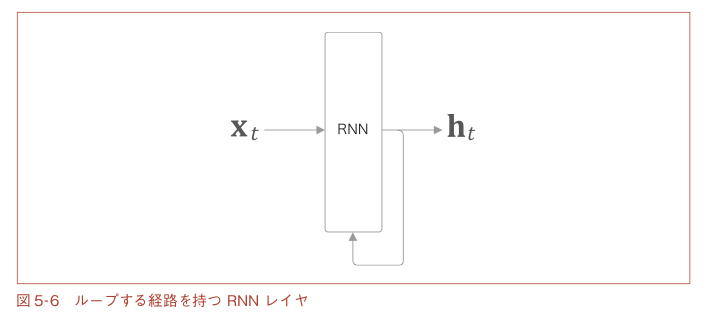

In [4]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig1.png'))

$\mathbf{X}_t $ と$\mathbf{h}_{t-1}$を入力され、$\mathbf{h}_t$を出力する。


### 鈴木メモ

Xは観測値で、hは（隠れ）状態。


言語モデルの導入に、RNNが必須ではないような気がする。
ただ、RNNを導入することが自然ではあると感じる。
自然言語は文脈があるし、次の単語は文脈に依存するとともに、
文脈自体は直前の単語によって変化するため。

文脈という概念を、数学的に表現する方法として隠れ状態を導入して、
隠れ状態を扱えるニューラルネットとしてRNNを導入したイメージ。

---



上記の図だと、4章まで


m語からなる文章を考える。各単語を$w_1, \cdots ,w_m$とする。
確率は同時確率として
$$
P(w_1,\cdots ,w_m)
$$
と書けるが、用いて分解でき、
$$
P(w_1, \cdots ,w_m) = P(w_m|w_1,\cdots , w_{m-1})P(w_{m-1}|w_1,\cdots ,w_{m-2})\cdots P(w_2|w_1)p(w_1)
$$
つまり、

最初の一語の確率＊（最初の一語の次に第二語が来る確率）＊（最初の二単語の次に、第三語が来る確率）＊ ・・・

と書くことができる。

乗法定理$P(A,B)=P(A|B)P(B)$を使っているとこの本には書いてあるが、あんまりこれを定理とは言わないような気がする。
条件付き確率の定義では？
ともかく、
$$
P(w_1, \cdots ,w_m) = \prod_{t=1}^m P(w_t|w_1,\cdots ,p_{t-1})
$$

がえられた。

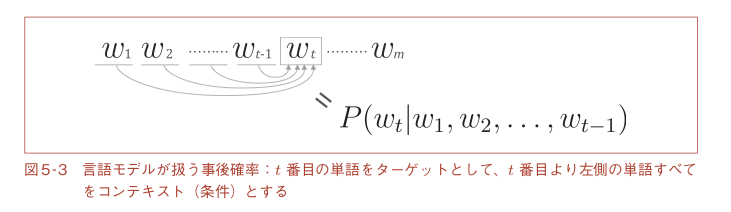

In [5]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig2.png'))


### 5.3.1 RNNレイヤの実装

In [0]:
# This is identical to common.time_layer.RNN
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### 5.3.2 TimeRNNレイヤの実装

In [0]:
# This is identical to common.time_layer.TimeRNN

from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


### 5.5.1 RNN LM の実装

In [0]:
# This code is identical to chap5.simply_rnnlm.SimpleRnnlm

import sys
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 402.34
| epoch 2 | perplexity 276.09
| epoch 3 | perplexity 229.10
| epoch 4 | perplexity 220.71
| epoch 5 | perplexity 209.11
| epoch 6 | perplexity 204.24
| epoch 7 | perplexity 199.42
| epoch 8 | perplexity 197.02
| epoch 9 | perplexity 192.15
| epoch 10 | perplexity 192.87
| epoch 11 | perplexity 188.65
| epoch 12 | perplexity 191.06
| epoch 13 | perplexity 189.18
| epoch 14 | perplexity 189.93
| epoch 15 | perplexity 189.10
| epoch 16 | perplexity 185.85
| epoch 17 | perplexity 182.50
| epoch 18 | perplexity 179.07
| epoch 19 | perplexity 181.46
| epoch 20 | perplexity 184.32
| epoch 21 | perplexity 179.25
| epoch 22 | perplexity 177.29
| epoch 23 | perplexity 171.99
| epoch 24 | perplexity 176.64
| epoch 25 | perplexity 175.44
| epoch 26 | perplexity 172.09
| epoch 27 | perplexity 166.37
| epoch 28 | perplexity 165.96
| epoch 29 | perplexity 163.90
| epoch 30 | perplexity 156.64
| epoch 31 | perplexity 158.11
| epoch 

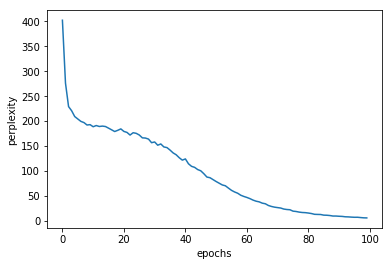

In [9]:
# This code is identical to chap5.train_custum_loop.py

import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
# from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 418.60
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 373.76
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 259.51
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 221.91
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 210.19
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 209.29
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 200.21
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.19
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 193.78
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 189.24
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.10
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 188.33
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 191.06
| epoch 14 |  iter 1 / 19 | time 1[s] | perplexity 185.92
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 185.14
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 189.21
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 187.48
| epoch 18 |  iter 1 / 

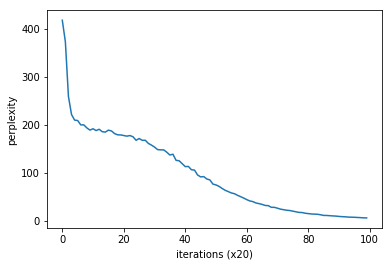

In [10]:
# This code is identical to chap5.train.py

from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
# from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()